In [1]:
from Eval_basis import *
import pandas as pd

[2019-08-07 15:58:34,377] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
np.random.seed(1)


In [3]:
data_full = EbiData("./data", experiment="E-ENAD-15")
data_big = UnionDataset("./data", map_fname="ensembl_mouse_genes-proteincoding", low_memory=False)
data_big.concat_union_from_memory([data_full])
data_big.filter_cell_types(np.array([ct for ct in data_big.cell_types if ct != "not available"]))

/home/michael/GitHub/scVI_ma/scvi/dataset/ebidata.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  adata.obs["batch_indices"][adata.obs["batch_indices"] == barcode] = i
[2019-08-07 15:59:51,883] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2019-08-07 15:59:51,889] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2019-08-07 15:59:51,897] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2019-08-07 15:59:51,904] WARNING - scvi.dataset.dataset | This dataset has some empty 

In [4]:
agg = data_full.obs.groupby(["Sample Characteristic[organism part]", "cell_types"]).size()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(agg.sort_index())

Sample Characteristic[organism part]      cell_types                                        
aorta                                     endothelial cell                                       188
                                          erythrocyte                                             91
                                          fibroblast                                              70
                                          not available                                          694
                                          professional antigen presenting cell                    59
ascending colon                           Brush cell of epithelium proper of large intestine      53
                                          enterocyte of epithelium of large intestine            761
                                          enteroendocrine cell                                    29
                                          epithelial cell of large intestine                    141

In [5]:
cutout_cts = agg["bone marrow"].index.values
if "not available" in cutout_cts:
    cutout_cts = np.delete(cutout_cts, np.where(cutout_cts == "not available")[0])
cutout_cts

array(['B cell', 'Slamf1-negative multipotent progenitor cell',
       'Slamf1-positive multipotent progenitor cell', 'basophil',
       'common lymphoid progenitor', 'granulocyte',
       'granulocyte monocyte progenitor cell',
       'hematopoietic precursor cell', 'immature B cell',
       'immature NK T cell', 'immature T cell',
       'immature natural killer cell', 'late pro-B cell', 'macrophage',
       'mature natural killer cell',
       'megakaryocyte-erythroid progenitor cell', 'monocyte',
       'naive B cell', 'pre-natural killer cell', 'pro-B cell',
       'regulatory T cell'], dtype=object)

In [7]:
rem_ct = data_big.cell_types[~np.isin(data_big.cell_types, cutout_cts)]


In [8]:
np.isin(cutout_cts, data_big.cell_types)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [11]:
data_small = copy.deepcopy(data_big)
# data_small.subsample_cells(0.7)
data_small.filter_cell_types(cutout_cts)
data_big.filter_cell_types(rem_ct)

[2019-08-07 16:02:30,994] INFO - scvi.dataset.dataset | Downsampled from 31394 to 5753 cells
[2019-08-07 16:02:31,903] INFO - scvi.dataset.dataset | Downsampled from 31394 to 25323 cells


In [12]:
# colors = {}
# cmap_regular = plt.get_cmap("tab20b", len(rem_ct))
# cmap_cutout = plt.get_cmap("tab20", len(cutout_ct))
# colors.update({label: cmap_regular(idx)
#                for idx, label in enumerate(rem_ct)})
# colors.update({label: cmap_cutout(idx)
#                for idx, label in enumerate(cutout_ct)})
colors=None
n_epochs = 100
trainer_big = train_vae(data_big, "./data", "big_bone_marrow_data_portion", n_epochs=n_epochs)
trainer_small = train_vae(data_small, "./data", "small_bone_marrow_data_portion", n_epochs=n_epochs)




training: 100%|██████████| 100/100 [03:55<00:00,  2.77s/it]


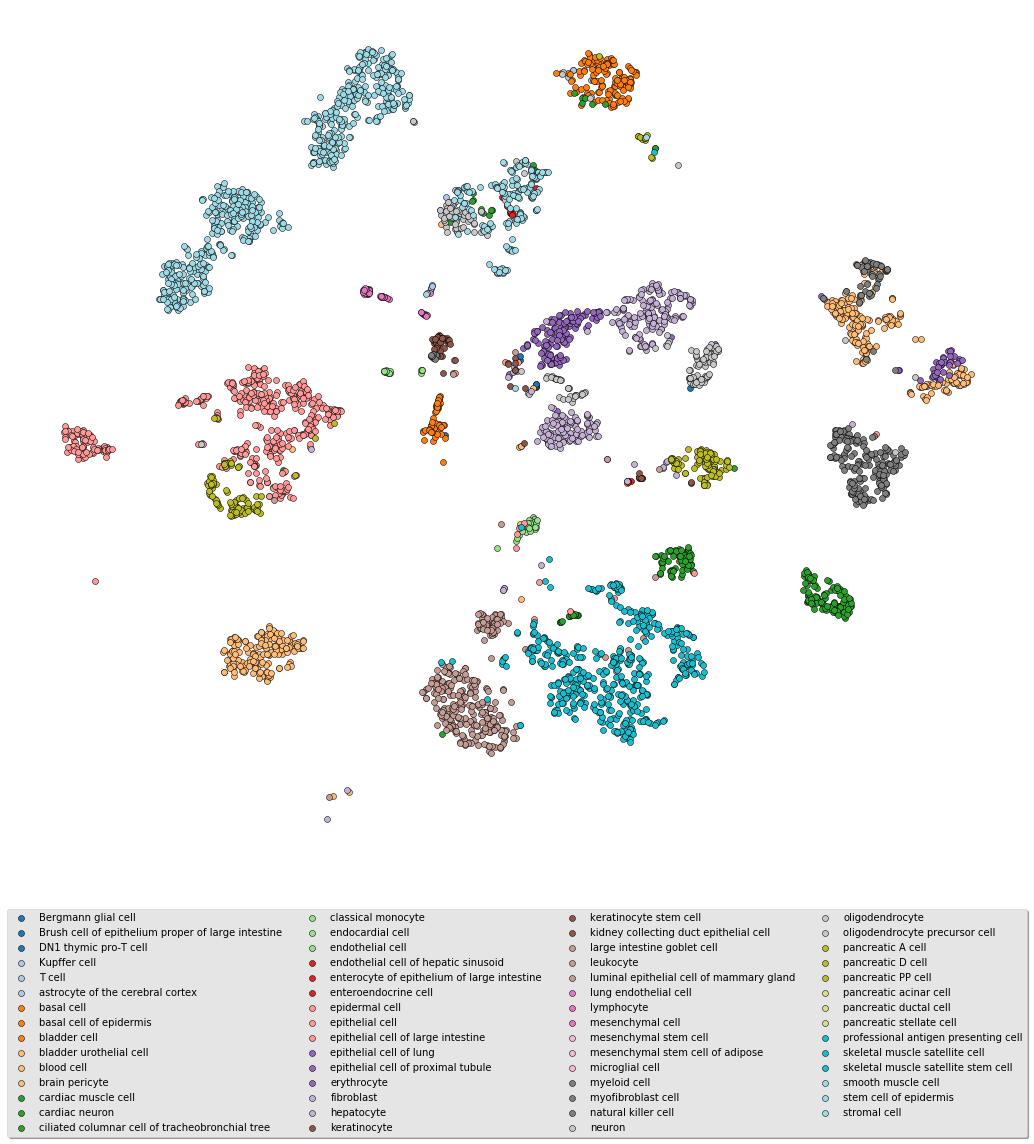

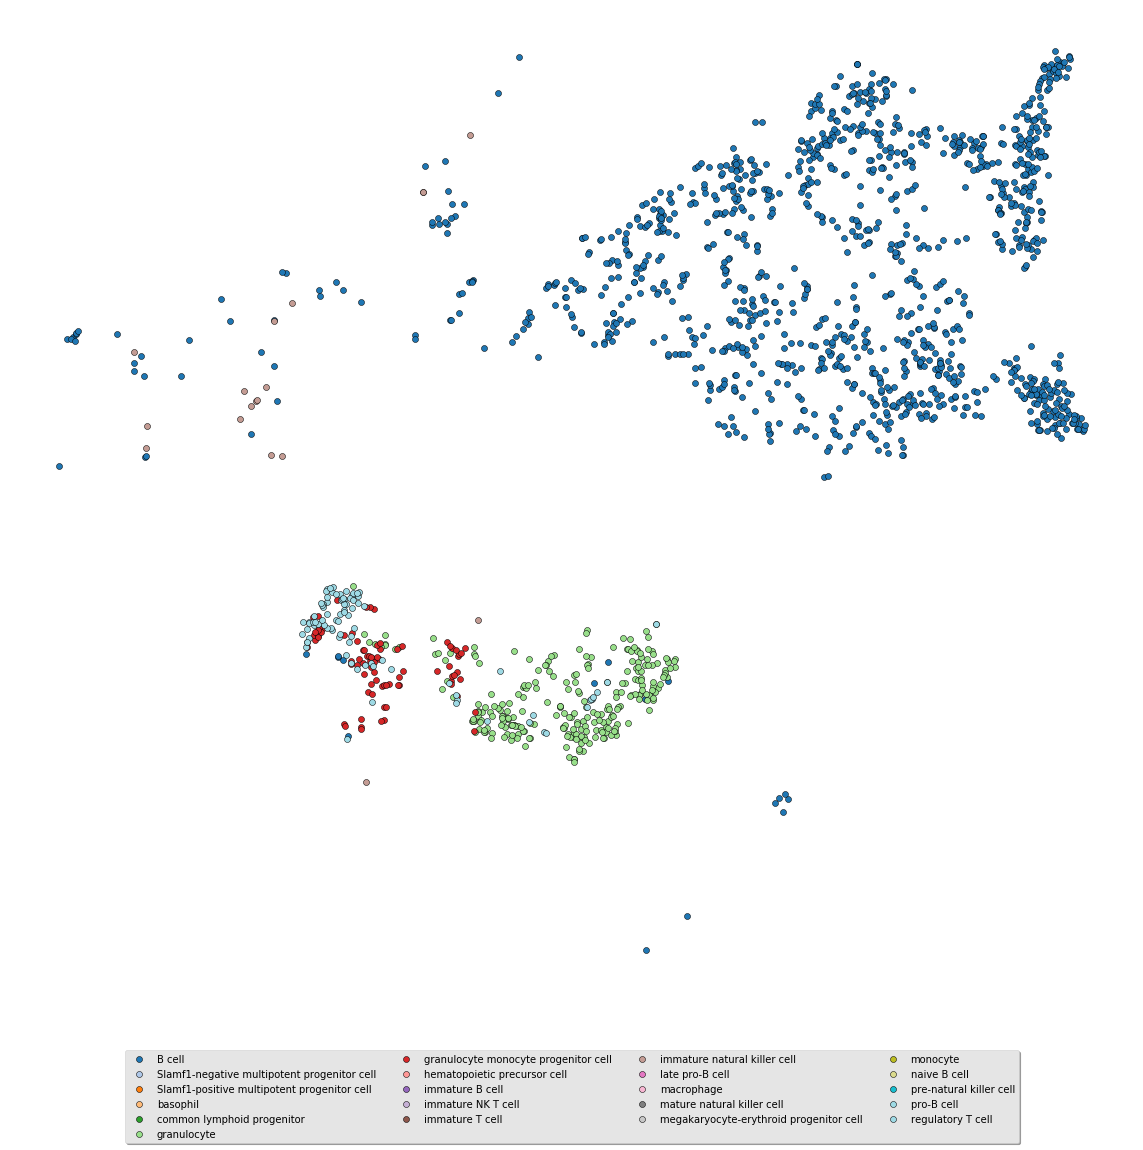

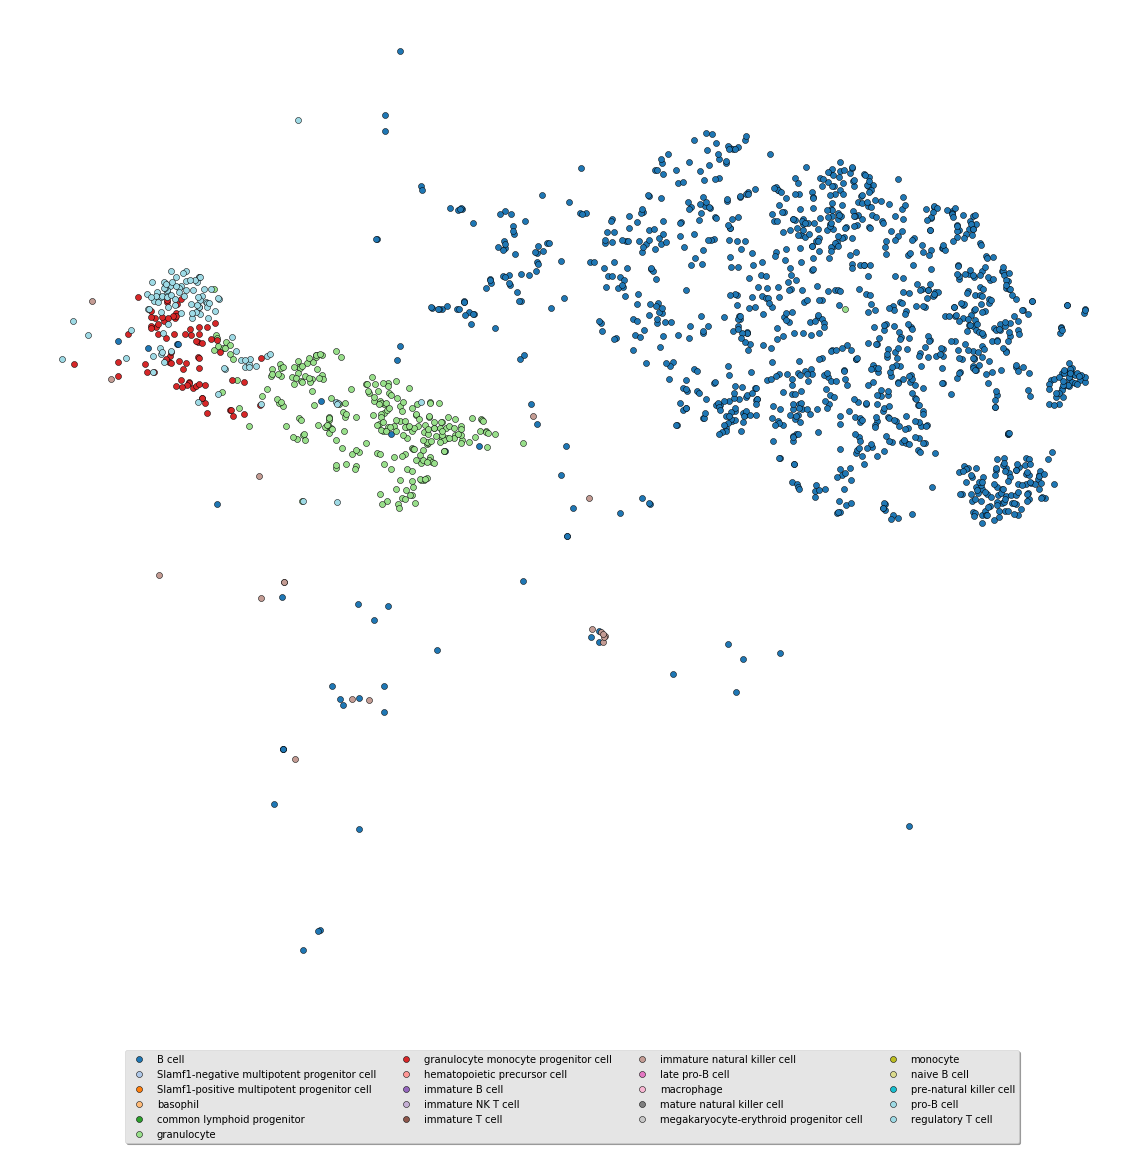

In [15]:
%matplotlib inline
dot_size = (mpl.rcParams['lines.markersize'] ** 2.0)

posterior_big = plot_tsne(trainer_big, trainer_big.model, data_big, "big_bone_marrow_data_portion",
                          colors=colors, s=dot_size, edgecolors='black')
posterior_small = plot_tsne(trainer_small, trainer_small.model, data_small, "small_bone_marrow_data_portion",
                            colors=colors, s=dot_size, edgecolors='black')
posterior_small_in_big = plot_tsne(trainer_big, trainer_big.model, data_small, "small_bone_marrow_data_portion_in_big",
                                   colors=colors, s=dot_size, edgecolors='black')
# plt.show()